## Initialize

### Import modules

In [653]:
import datetime
import math
import os

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import shioaji as sj
import talib as ta
import torch
import wandb

from tqdm import tqdm

### Hyper parameters and parameters

In [654]:
## Hyperparameters
SEQ_LEN = 32
BATCH_SIZE = 64
EPOCHS = 50
D_MODEL = 20
NUM_HEADS = 10
NUM_ENCODER_LAYERS = 6
DROPOUT_RATE = 0.05
LEARNING_RATE = 1e-4

## Parameters
MIN_LATER = 1  # The minute we want to predict in the future
DEVICE = (torch.cuda.is_available() and 'cuda:0') or 'cpu'

### Connect with weight and bias website

In [655]:
wandb.init(
    project = "transformer",

    config = {
        "architecture": "transformer",
        "dataset": "TXF and TSMC",
        "Kbar_timeunit": "15min",
        "LOSS_FUNC": "MSE",
        "OPTIMIZER": "adam",

        "SEQ_LEN": SEQ_LEN,
        "BATCH_SIZE": BATCH_SIZE,
        "EPOCHS": EPOCHS,
        "D_MODEL": D_MODEL,
        "NUM_HEADS": NUM_HEADS,
        "NUM_ENCODER_LAYERS": NUM_ENCODER_LAYERS,
        "DROPOUT_RATE": DROPOUT_RATE,
        "LEANING_RATE": LEARNING_RATE,

        "MIN_LATER": MIN_LATER,

        "EPSILON": 1e-8,
        "BETA": (0.9, 0.98),
        "WEIGHT_DECAY": 0.02,
    }
)

average_loss,████▇▇▇▇▆▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
average_validation_loss,████▇▇▇▇▆▆▅▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,████▇▇▇▇▆▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,████▇▇▇▇▆▆▅▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
average_loss,2486429.30838
average_validation_loss,8926810.07936
loss,606688751.24403
validation_loss,267804302.38086


### Plot function

In [656]:
def draw_plot(x_data: pd.DataFrame, y_data: pd.DataFrame, x_label: str, y_label: str) -> None:
    fig = plt.figure(figsize=(7, 4))
    plt.scatter(x_data, y_data, s = 1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

### Indicators function

In [657]:
def keltner_bands(close: np.ndarray, high: np.ndarray, low: np.ndarray, period: int, multiplier: int) -> tuple:
    mid = ta.EMA(close, timeperiod = period)
    mid = np.nan_to_num(mid, nan = mid[period - 1])
    kelt_trange = np.array([])

    for i in tqdm(range(1, len(close)), desc = "Calculating kelner bands "):
        tem_trange = max(
            high[-i] - low[-i],
            abs(high[-i] - close[-i - 1]),
            abs(low[-i] - close[-i - 1])
        )
        kelt_trange = np.append(tem_trange, kelt_trange)
    kelt_trange = np.append(high[0] - low[0], kelt_trange)
    atr = ta.EMA(kelt_trange, timeperiod = period)
    atr = np.nan_to_num(atr, nan = atr[period - 1])
    upper = mid + atr * multiplier
    lower = mid - atr * multiplier

    return upper, mid, lower

In [658]:
def KDJ(high: np.ndarray, low: np.ndarray, close: np.ndarray, period: int, signal_k: int, signal_d: int) -> tuple:
    _alpha_k = 2 / (signal_k + 1)
    _alpha_d = 2 / (signal_d + 1)

    lowest = ta.MIN(low, timeperiod = period)
    lowest = np.nan_to_num(lowest, nan = lowest[period - 1])
    highest = ta.MAX(high, timeperiod = period)
    highest = np.nan_to_num(highest, nan = highest[period - 1])

    rsv = (close - lowest) / (highest - lowest) * 100
    
    K = np.array([50])
    D = np.array([50])
    J = np.array([50])
    
    for i in tqdm(range(1, len(close)), desc = "Calculating KDJ "):
        K = np.append(K, int(_alpha_k * ((K[-1] + 2 * rsv[i]) / 3) + (1 - _alpha_k) * K[-1] + 0.5))
        D = np.append(D,  int(_alpha_d * ((D[-1] + 2 * K[-1]) / 3) + (1 - _alpha_d) * D[-1] + 0.5))
        J = np.append(J, 3 * K[-1] - 2 * D[-1])

    return K, D, J

## Data preprocess

### Load data and split into train/test set

In [659]:
TXF_path = 'data/TXFR1_1min.csv'
TSMC_path = 'data/2330_1min.csv'

TXF = pd.read_csv(TXF_path)
TSMC = pd.read_csv(TSMC_path)

TXF.index = pd.to_datetime(TXF.ts)
TSMC.index = pd.to_datetime(TSMC.ts)

## Align the index of two dataframes
common_index = TXF.index.intersection(TSMC.index)

TXF = TXF.loc[common_index]
TSMC = TSMC.loc[common_index]

In [660]:
TXF.head()

,ts,Open,High,Low,Close,Volume,Amount
ts,,,,,,,
2020-03-02 09:01:00,2020-03-02 09:01:00,11068.0,11084.0,11041.0,11044.0,2368,26207768.0
2020-03-02 09:02:00,2020-03-02 09:02:00,11042.0,11064.0,11040.0,11060.0,2242,24784906.0
2020-03-02 09:03:00,2020-03-02 09:03:00,11061.0,11095.0,11060.0,11086.0,2017,22350722.0
2020-03-02 09:04:00,2020-03-02 09:04:00,11086.0,11092.0,11071.0,11078.0,1490,16512119.0
2020-03-02 09:05:00,2020-03-02 09:05:00,11078.0,11086.0,11068.0,11071.0,912,10101762.0


In [661]:
TSMC.head()

,ts,Open,High,Low,Close,Volume,Amount
ts,,,,,,,
2020-03-02 09:01:00,2020-03-02 09:01:00,308.0,308.5,308.0,308.5,12311,3.792677e+09
2020-03-02 09:02:00,2020-03-02 09:02:00,308.5,308.5,308.5,308.5,773,2.384705e+08
2020-03-02 09:03:00,2020-03-02 09:03:00,308.5,309.0,308.5,308.5,642,1.981785e+08
2020-03-02 09:04:00,2020-03-02 09:04:00,309.0,309.0,308.5,309.0,600,1.853700e+08
2020-03-02 09:05:00,2020-03-02 09:05:00,309.0,309.0,309.0,309.0,1079,3.334110e+08


In [662]:
print(f'TXF shape: {TXF.shape}')
print(f'CDF shape: {TSMC.shape}')

TXF shape: (289748, 7)
CDF shape: (289748, 7)


In [663]:
## Split the data into training, validating and testing set by 8:1:1
TXF_train = TXF.iloc[ : int(TXF.shape[0] * 0.8)]
TXF_valid = TXF.iloc[int(TXF.shape[0] * 0.8) : int(TXF.shape[0] * 0.9)]
TXF_test = TXF.iloc[int(TXF.shape[0] * 0.9) : ]

TSMC_train = TSMC.iloc[ : int(TSMC.shape[0] * 0.8)]
TSMC_valid = TSMC.iloc[int(TSMC.shape[0] * 0.8) : int(TSMC.shape[0] * 0.9)]
TSMC_test = TSMC.iloc[int(TSMC.shape[0] * 0.9) : ]

print(f'train size: {TXF_train.shape[0]}')
print(f'valid size: {TXF_valid.shape[0]}')
print(f'test size: {TXF_test.shape[0]}')

train size: 231798
valid size: 28975
test size: 28975


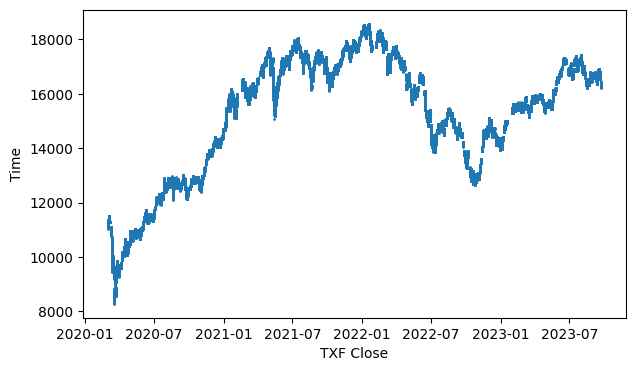

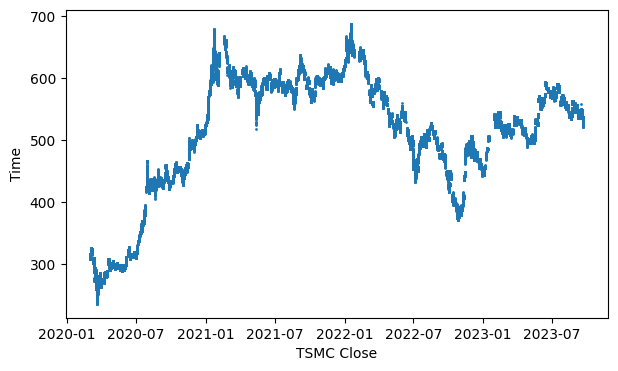

In [664]:
draw_plot(TXF_train.index, TXF_train.Close, 'TXF Close', 'Time')
draw_plot(TSMC_train.index, TSMC_train.Close, 'TSMC Close', 'Time')

### Dataset and DataLoader

In [665]:
## Dataset and DataLoader
class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, TXF, TSMC):
        self.TXF = torch.cat((
            torch.unsqueeze(torch.tensor(TXF.Open.values), 1),
            torch.unsqueeze(torch.tensor(TXF.High.values), 1),
            torch.unsqueeze(torch.tensor(TXF.Low.values), 1),
            torch.unsqueeze(torch.tensor(TXF.Close.values), 1),
            torch.unsqueeze(torch.tensor(TXF.Volume.values), 1)
        ), 1)
        self.TSMC = torch.unsqueeze(torch.tensor(TSMC.Close.values), 1)
        # print(self.TXF.shape)
        # print(self.TSMC.shape)

        self.TXF_close = torch.unsqueeze(torch.tensor(TXF.Close.values), 1).double()
        # print(self.TXF_close.shape)

        self.data_len = self.TXF.shape[0]

        self.sma_short = ta.SMA(TXF.Close, timeperiod = 3)
        self.sma_short = torch.tensor(np.nan_to_num(self.sma_short, nan = self.sma_short.iloc[2]))
        self.sma_short = torch.unsqueeze(self.sma_short, 1)

        self.sma_long = ta.SMA(TXF.Close, timeperiod = 9)
        self.sma_long = torch.tensor(np.nan_to_num(self.sma_long, nan = self.sma_long.iloc[8]))
        self.sma_long = torch.unsqueeze(self.sma_long, 1)

        self.adosc = ta.ADOSC(TXF.High, TXF.Low, TXF.Close, TXF.Volume, fastperiod = 6, slowperiod = 15)
        self.adosc = torch.tensor(np.nan_to_num(self.adosc, nan = self.adosc.iloc[14]))
        self.adosc = torch.unsqueeze(self.adosc, 1)

        self.bband_upper, self.bband_middle, self.bband_lower = ta.BBANDS(TXF.Close, timeperiod = 20, nbdevup = 2, nbdevdn = 2)
        self.bband_upper = torch.tensor(np.nan_to_num(self.bband_upper, nan = self.bband_upper.iloc[19]))
        self.bband_upper = torch.unsqueeze(self.bband_upper, 1)

        self.bband_middle = torch.tensor(np.nan_to_num(self.bband_middle, nan = self.bband_middle.iloc[19]))
        self.bband_middle = torch.unsqueeze(self.bband_middle, 1)

        self.bband_lower = torch.tensor(np.nan_to_num(self.bband_lower, nan = self.bband_lower.iloc[19]))
        self.bband_lower = torch.unsqueeze(self.bband_lower, 1)

        self.keltner_upper, self.keltner_middle, self.keltner_lower = keltner_bands(
            TXF.Close.values, TXF.High.values, TXF.Low.values, 
            20, 1.5
        )
        self.keltner_upper = torch.tensor(self.keltner_upper)
        self.keltner_upper = torch.unsqueeze(self.keltner_upper, 1)

        self.keltner_middle = torch.tensor(self.keltner_middle)
        self.keltner_middle = torch.unsqueeze(self.keltner_middle, 1)

        self.keltner_lower = torch.tensor(self.keltner_lower)
        self.keltner_lower = torch.unsqueeze(self.keltner_lower, 1)

        self.K, self.D, self.J = KDJ(TXF.High.values, TXF.Low.values, TXF.Close.values, 25, 3, 3)
        self.K = torch.tensor(self.K)
        self.K = torch.unsqueeze(self.K, 1)

        self.D = torch.tensor(self.D)
        self.D = torch.unsqueeze(self.D, 1)

        self.J = torch.tensor(self.J)
        self.J = torch.unsqueeze(self.J, 1)

    def __len__(self):
        return self.data_len - (SEQ_LEN + MIN_LATER + 1) - 1
    
    def __getitem__(self, idx):
        x_data = torch.cat((
            self.TXF[idx : idx + SEQ_LEN],
            self.TSMC[idx : idx + SEQ_LEN],
            self.sma_short[idx : idx + SEQ_LEN],
            self.sma_long[idx : idx + SEQ_LEN],
            self.adosc[idx : idx + SEQ_LEN],
            self.bband_upper[idx : idx + SEQ_LEN],
            self.bband_middle[idx : idx + SEQ_LEN],
            self.bband_lower[idx : idx + SEQ_LEN],
            self.keltner_upper[idx : idx + SEQ_LEN],
            self.keltner_middle[idx : idx + SEQ_LEN],
            self.keltner_lower[idx : idx + SEQ_LEN],
            self.K[idx : idx + SEQ_LEN],
            self.D[idx : idx + SEQ_LEN],
            self.J[idx : idx + SEQ_LEN]
        ), 1)

        y_data = self.TXF_close[idx + SEQ_LEN + MIN_LATER + 1]

        return x_data, y_data
    
train_dataset = custom_dataset(TXF_train, TSMC_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, pin_memory = True, drop_last = True)

valid_dataset = custom_dataset(TXF_valid, TSMC_valid)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True, pin_memory = True, drop_last = True)

test_dataset = custom_dataset(TXF_test, TSMC_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, pin_memory = True, drop_last = True)

Calculating KDJ : 100%|██████████| 28974/28974 [00:00<00:00, 56952.48it/s]


In [666]:
test = iter(torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False))
test_x, test_y = next(test)
FEATURE_NUM = test_x.shape[2]

print(f'In every data: ')
print(f'\tx_data shape: {test_x[0].shape}')
print(f'\ty_data shape: {test_y[0].shape}\n')
print(f'Which means we use the past [{SEQ_LEN}] minutes data to predict the price in [{MIN_LATER}] minutes later')

In every data: 
	x_data shape: torch.Size([32, 18])
	y_data shape: torch.Size([1])

Which means we use the past [32] minutes data to predict the price in [1] minutes later


In [667]:
print(test_x.shape)
print(test_y.shape)

torch.Size([64, 32, 18])
torch.Size([64, 1])


## Model

### Model implementation

#### Position embedding layer

In [668]:
class PositionEmbedding(torch.nn.Module):
    def __init__(self, d_model: int) -> None:
        super(PositionEmbedding, self).__init__()
        self.linear = torch.nn.Linear(FEATURE_NUM, d_model, dtype = torch.double)

        # Create a matrix of shape (max_len, feature_num)
        pe = torch.zeros(SEQ_LEN, d_model)
        position = torch.arange(0, SEQ_LEN, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # Add a batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = self.linear(x)
        x = x + self.pe[:, :x.size(1)]
        return x

#### Multi-head attention layer

In [669]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model: int, num_heads: int) -> None:
        super(MultiHeadAttention, self).__init__()
        
        # d_model should be divisible by num_heads
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.V_linear = torch.nn.Linear(d_model, d_model, dtype = torch.double)
        self.K_linear = torch.nn.Linear(d_model, d_model, dtype = torch.double)
        self.Q_linear = torch.nn.Linear(d_model, d_model, dtype = torch.double)
        self.output_linear = torch.nn.Linear(d_model, d_model, dtype = torch.double)

    def scaled_dot_product_attention(self, Q: torch.tensor, K: torch.tensor, V: torch.tensor) -> torch.tensor:
        # Q, V: [batch_size, num_heads, seq_len, d_k]
        # K: [batch_size, num_heads, seq_len, d_k] -> K: [batch_size, num_heads, d_k, seq_len]
        # attention: [batch_size, num_heads, seq_len, seq_len]
        attention = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k).float())

        # attention_prob: [batch_size, num_heads, seq_len, seq_len]
        # It satisfies the sum of the last dimension is 1
        # For example, assume the result of this softmax is a
        # then a[0][0][0][0] + a[0][0][0][1] + ... + a[0][0][0][seq_len - 1] = 1
        attention_prob = torch.nn.functional.softmax(attention, dim = -1)
        output = torch.matmul(attention_prob, V)
        return output
    
    def split_heads(self, x: torch.tensor) -> torch.tensor:
        batch_size, seq_len, d_model = x.size()

        # x: [batch_size, seq_len, d_model] -> x: [batch_size, num_heads, seq_len, d_k]
        x = x.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        return x
    
    def concat_heads(self, x: torch.tensor) -> torch.tensor:
        batch_size, _, seq_len, d_k = x.size()

        # x: [batch_size, num_heads, seq_len, d_k] -> x: [batch_size, seq_len, d_model]
        x = x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return x
    
    def forward(self, Q: torch.tensor, K: torch.tensor, V: torch.tensor) -> torch.tensor:
        Q = self.split_heads(self.Q_linear(Q))
        K = self.split_heads(self.K_linear(K))
        V = self.split_heads(self.V_linear(V))
        # print("-> Split head succeeded!")

        attention_output = self.scaled_dot_product_attention(Q, K, V)
        # print("-> Scaled dot product attention succeeded!")

        output = self.output_linear(self.concat_heads(attention_output))
        # print("-> Concat head succeeded!")
        
        return output

#### Feed forward layer

In [670]:
class FeedForward(torch.nn.Module):
    def __init__(self, d_model: int, d_ff: int) -> None:
        super(FeedForward, self).__init__()
        # self.fully_connected_1 = torch.nn.Linear(d_model, d_ff, dtype = torch.double)
        # self.fully_connected_2 = torch.nn.Linear(d_ff, d_model, dtype = torch.double)
        self.conv1d_1 = torch.nn.Conv1d(in_channels = d_model, out_channels = d_ff, kernel_size = 1, dtype = torch.double)
        self.conv1d_2 = torch.nn.Conv1d(in_channels = d_ff, out_channels = d_model, kernel_size = 1, dtype = torch.double)
        self.relu = torch.nn.ReLU()

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = x.transpose(1, 2)
        nonliear_output_1 = self.relu(self.conv1d_1(x))
        output = self.conv1d_2(nonliear_output_1)
        return output.transpose(1, 2)


#### Encoder layer

In [671]:
class Encoder(torch.nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout_rate: int) -> None:
        super(Encoder, self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_model * 4)
        self.norm_1 = torch.nn.LayerNorm(d_model, dtype = torch.double)
        self.norm_2 = torch.nn.LayerNorm(d_model, dtype = torch.double)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # print("Start to encode...")
        attention_output = self.multi_head_attention(x, x, x)
        # print("Get the attention output!\n")

        # print("Start to feed forward...")
        feed_forward_input = self.norm_1(x + self.dropout(attention_output))
        feed_forward_output = self.feed_forward(feed_forward_input)
        output = self.norm_2(feed_forward_input + self.dropout(feed_forward_output))
        # print("Get the feed forward output!\n")
        
        return output

#### Transformer model

In [672]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model: int, num_heads: int, num_layers: int, dropout_rate: int) -> None:
        super(Transformer, self).__init__()
        self.d_model = d_model

        self.position_embedding = PositionEmbedding(d_model)
        self.encoder = torch.nn.ModuleList([Encoder(d_model, num_heads, dropout_rate) for _ in range(num_layers)])
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.prepare_output = torch.nn.Linear(SEQ_LEN * D_MODEL, 64, dtype = torch.double)
        self.relu = torch.nn.ReLU()
        self.final_layer = torch.nn.Linear(64, 1, dtype = torch.double)

    def forward(self, x):
        x = self.position_embedding(x)

        encoder_output = x
        for encoder in self.encoder:
            encoder_output = encoder(encoder_output)

        encoder_output = encoder_output.view(encoder_output.shape[0], -1)

        # [batch_size, seq_len] -> [batch_size, 64]
        flatten_encoder_output = self.dropout(self.prepare_output(encoder_output))

        output = self.final_layer(flatten_encoder_output)
        return output

### Define Model

In [673]:
transformer = Transformer(
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    num_layers = NUM_ENCODER_LAYERS,
    dropout_rate = DROPOUT_RATE
).to(device = DEVICE)

criterion = torch.nn.MSELoss().to(device = DEVICE)
optimizer = torch.optim.Adam(transformer.parameters(), lr = LEARNING_RATE, betas=(0.9, 0.98), eps=1e-8, weight_decay = 0.02)

In [674]:
torch.cuda.device(0)
torch.cuda.empty_cache()
torch.cuda.set_device(0)

transformer.train()

Transformer(
  (position_embedding): PositionEmbedding(
    (linear): Linear(in_features=18, out_features=20, bias=True)
  )
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (multi_head_attention): MultiHeadAttention(
        (V_linear): Linear(in_features=20, out_features=20, bias=True)
        (K_linear): Linear(in_features=20, out_features=20, bias=True)
        (Q_linear): Linear(in_features=20, out_features=20, bias=True)
        (output_linear): Linear(in_features=20, out_features=20, bias=True)
      )
      (feed_forward): FeedForward(
        (conv1d_1): Conv1d(20, 80, kernel_size=(1,), stride=(1,))
        (conv1d_2): Conv1d(80, 20, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (norm_1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (dropout): Dropout(p=0.05, inplace=False)
  (prepare_output): Linear(in_features=64

### Start Train and Validate

In [675]:
best_average_vloss = float('inf')
model_path = ""

for epoch in tqdm(range(EPOCHS)):
    transformer.train()

    epoch_loss = 0
    for x_data, y_data in train_dataloader:
        x_data = x_data.to(device = DEVICE)
        y_data = y_data.to(device = DEVICE)

        optimizer.zero_grad()
        output = transformer(x_data)
        loss = criterion(output, y_data)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f'Epoch: {epoch + 1}, Average Loss: {epoch_loss / len(train_dataloader)}')
    wandb.log({'loss': epoch_loss})
    wandb.log({'average_loss': epoch_loss / len(train_dataloader)})

    transformer.eval()
    epoch_vloss = 0
    with torch.no_grad():
        for x_data, y_data in valid_dataloader:
            x_data = x_data.to(device = DEVICE)
            y_data = y_data.to(device = DEVICE)

            voutput = transformer(x_data)
            vloss = criterion(output, y_data)
            epoch_vloss += vloss.item()
    
    print(f'Epoch: {epoch + 1}, Average Validation Loss: {epoch_vloss / len(valid_dataloader)}')
    wandb.log({'validation_loss': epoch_vloss})
    wandb.log({'average_validation_loss': epoch_vloss / len(valid_dataloader)})

    if epoch_vloss / len(valid_dataloader) < best_average_vloss:
        if os.path.exists(model_path):
            os.remove(model_path)

        best_average_vloss = epoch_vloss / len(valid_dataloader)
        model_path = f'model_{epoch + 1}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.pth'
        torch.save(transformer.state_dict(), model_path)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Average Loss: 146631021.0109386


  2%|▏         | 1/50 [01:52<1:31:52, 112.50s/it]

Epoch: 1, Average Validation Loss: 34977663.820473135
Epoch: 2, Average Loss: 5225939.810796122


  4%|▍         | 2/50 [03:45<1:30:01, 112.52s/it]

Epoch: 2, Average Validation Loss: 8945718.286588062
Epoch: 3, Average Loss: 3445842.791119602


  6%|▌         | 3/50 [05:38<1:28:24, 112.85s/it]

Epoch: 3, Average Validation Loss: 9109485.644817267
Epoch: 4, Average Loss: 2753340.80805393


  8%|▊         | 4/50 [07:30<1:26:26, 112.75s/it]

Epoch: 4, Average Validation Loss: 11461688.88156223
Epoch: 5, Average Loss: 2506737.500176632


 10%|█         | 5/50 [09:23<1:24:31, 112.70s/it]

Epoch: 5, Average Validation Loss: 9765648.29008333
Epoch: 6, Average Loss: 2384978.778856119


 12%|█▏        | 6/50 [11:17<1:23:01, 113.21s/it]

Epoch: 6, Average Validation Loss: 9432844.066500494
Epoch: 7, Average Loss: 2280498.641690132


 14%|█▍        | 7/50 [13:10<1:21:06, 113.18s/it]

Epoch: 7, Average Validation Loss: 7311593.205709219
Epoch: 8, Average Loss: 2193825.947628402


 16%|█▌        | 8/50 [15:03<1:19:08, 113.05s/it]

Epoch: 8, Average Validation Loss: 13981105.571392706
Epoch: 9, Average Loss: 2123863.61457607


 18%|█▊        | 9/50 [16:56<1:17:14, 113.04s/it]

Epoch: 9, Average Validation Loss: 11067761.65928904
Epoch: 10, Average Loss: 2086638.5890203353


 20%|██        | 10/50 [18:49<1:15:14, 112.86s/it]

Epoch: 10, Average Validation Loss: 7343892.87931204
Epoch: 11, Average Loss: 1996152.9093595222


 22%|██▏       | 11/50 [20:41<1:13:18, 112.79s/it]

Epoch: 11, Average Validation Loss: 4794640.931511276
Epoch: 12, Average Loss: 1943513.0776680089


 24%|██▍       | 12/50 [22:34<1:11:22, 112.70s/it]

Epoch: 12, Average Validation Loss: 9555496.228418257
Epoch: 13, Average Loss: 1877514.0151116094


 26%|██▌       | 13/50 [24:26<1:09:27, 112.63s/it]

Epoch: 13, Average Validation Loss: 11927588.611628331
Epoch: 14, Average Loss: 1816981.7173108715


 28%|██▊       | 14/50 [26:19<1:07:34, 112.62s/it]

Epoch: 14, Average Validation Loss: 11859574.418494938
Epoch: 15, Average Loss: 1761707.68525444


 30%|███       | 15/50 [28:11<1:05:42, 112.64s/it]

Epoch: 15, Average Validation Loss: 10188261.224713517
Epoch: 16, Average Loss: 1736645.5020157641


 32%|███▏      | 16/50 [30:05<1:03:54, 112.78s/it]

Epoch: 16, Average Validation Loss: 7257680.91771079
Epoch: 17, Average Loss: 1715365.1170724689


 34%|███▍      | 17/50 [31:58<1:02:04, 112.86s/it]

Epoch: 17, Average Validation Loss: 13051722.1319173
Epoch: 18, Average Loss: 1668556.4935163658


 36%|███▌      | 18/50 [33:51<1:00:12, 112.89s/it]

Epoch: 18, Average Validation Loss: 9864250.667824104
Epoch: 19, Average Loss: 1635141.0381648203


 38%|███▊      | 19/50 [35:44<58:20, 112.92s/it]  

Epoch: 19, Average Validation Loss: 5641971.300407512
Epoch: 20, Average Loss: 1616421.0923619966


 40%|████      | 20/50 [37:38<56:45, 113.51s/it]

Epoch: 20, Average Validation Loss: 9487307.092461303
Epoch: 21, Average Loss: 1570741.564559567


 42%|████▏     | 21/50 [39:32<54:54, 113.60s/it]

Epoch: 21, Average Validation Loss: 10725019.814873105
Epoch: 22, Average Loss: 1568570.4095940702


 44%|████▍     | 22/50 [41:26<53:02, 113.67s/it]

Epoch: 22, Average Validation Loss: 8103993.140042861
Epoch: 23, Average Loss: 1533742.8040132024


 46%|████▌     | 23/50 [43:20<51:07, 113.61s/it]

Epoch: 23, Average Validation Loss: 9447128.149529718
Epoch: 24, Average Loss: 1493239.0056042476


 48%|████▊     | 24/50 [45:13<49:12, 113.56s/it]

Epoch: 24, Average Validation Loss: 10375594.482604975
Epoch: 25, Average Loss: 1479664.8696924427


 50%|█████     | 25/50 [47:06<47:17, 113.49s/it]

Epoch: 25, Average Validation Loss: 10994603.750289
Epoch: 26, Average Loss: 1450649.0117185554


 52%|█████▏    | 26/50 [48:59<45:21, 113.39s/it]

Epoch: 26, Average Validation Loss: 12638119.55948872
Epoch: 27, Average Loss: 1422634.1817698565


 54%|█████▍    | 27/50 [50:53<43:25, 113.30s/it]

Epoch: 27, Average Validation Loss: 11782911.406297408
Epoch: 28, Average Loss: 1377502.855456713


 56%|█████▌    | 28/50 [52:46<41:34, 113.39s/it]

Epoch: 28, Average Validation Loss: 11467403.963987011
Epoch: 29, Average Loss: 1331096.213443772


 58%|█████▊    | 29/50 [54:39<39:40, 113.35s/it]

Epoch: 29, Average Validation Loss: 11151113.64692151
Epoch: 30, Average Loss: 1282730.1937943313


 60%|██████    | 30/50 [56:33<37:46, 113.34s/it]

Epoch: 30, Average Validation Loss: 8515543.987767825
Epoch: 31, Average Loss: 1234820.5943989838


 62%|██████▏   | 31/50 [58:26<35:54, 113.39s/it]

Epoch: 31, Average Validation Loss: 8766577.030283015
Epoch: 32, Average Loss: 1218124.5370787808


 64%|██████▍   | 32/50 [1:00:20<34:00, 113.37s/it]

Epoch: 32, Average Validation Loss: 11305431.323941842
Epoch: 33, Average Loss: 1176860.339737114


 66%|██████▌   | 33/50 [1:02:13<32:06, 113.34s/it]

Epoch: 33, Average Validation Loss: 11714169.875473803
Epoch: 34, Average Loss: 1151483.6899135234


 68%|██████▊   | 34/50 [1:04:06<30:14, 113.38s/it]

Epoch: 34, Average Validation Loss: 10048001.476276256
Epoch: 35, Average Loss: 1146244.8828021097


 70%|███████   | 35/50 [1:05:59<28:19, 113.27s/it]

Epoch: 35, Average Validation Loss: 8698693.299260305
Epoch: 36, Average Loss: 1129594.4915186227


 72%|███████▏  | 36/50 [1:07:53<26:25, 113.25s/it]

Epoch: 36, Average Validation Loss: 8361208.667616188
Epoch: 37, Average Loss: 1113926.13258322


 74%|███████▍  | 37/50 [1:09:46<24:32, 113.24s/it]

Epoch: 37, Average Validation Loss: 10302676.240127994
Epoch: 38, Average Loss: 1109357.5402846413


 76%|███████▌  | 38/50 [1:11:39<22:38, 113.23s/it]

Epoch: 38, Average Validation Loss: 11317118.619379736
Epoch: 39, Average Loss: 1102027.5236042084


 78%|███████▊  | 39/50 [1:13:32<20:46, 113.32s/it]

Epoch: 39, Average Validation Loss: 9755117.797572937
Epoch: 40, Average Loss: 1085461.5111128662


 80%|████████  | 40/50 [1:15:26<18:53, 113.36s/it]

Epoch: 40, Average Validation Loss: 12172524.561967518
Epoch: 41, Average Loss: 1049550.1606251097


 82%|████████▏ | 41/50 [1:17:19<16:59, 113.28s/it]

Epoch: 41, Average Validation Loss: 7471880.602900841
Epoch: 42, Average Loss: 1048902.3935783857


 84%|████████▍ | 42/50 [1:19:13<15:07, 113.41s/it]

Epoch: 42, Average Validation Loss: 9179599.21820028
Epoch: 43, Average Loss: 1032379.9890454153


 86%|████████▌ | 43/50 [1:21:08<13:17, 113.88s/it]

Epoch: 43, Average Validation Loss: 9221171.923328366
Epoch: 44, Average Loss: 1025554.2741632803


 88%|████████▊ | 44/50 [1:23:04<11:27, 114.54s/it]

Epoch: 44, Average Validation Loss: 10599261.851395622
Epoch: 45, Average Loss: 1012055.8698865937


 90%|█████████ | 45/50 [1:24:58<09:32, 114.43s/it]

Epoch: 45, Average Validation Loss: 10750951.021899309
Epoch: 46, Average Loss: 1001397.773718962


 92%|█████████▏| 46/50 [1:26:52<07:37, 114.36s/it]

Epoch: 46, Average Validation Loss: 8452044.376163892
Epoch: 47, Average Loss: 997958.0951944765


 94%|█████████▍| 47/50 [1:28:46<05:42, 114.17s/it]

Epoch: 47, Average Validation Loss: 12356337.768189369
Epoch: 48, Average Loss: 992389.9025075223


 96%|█████████▌| 48/50 [1:30:39<03:47, 113.90s/it]

Epoch: 48, Average Validation Loss: 11915511.444091372
Epoch: 49, Average Loss: 976362.138302203


 98%|█████████▊| 49/50 [1:32:32<01:53, 113.71s/it]

Epoch: 49, Average Validation Loss: 9470443.179846443
Epoch: 50, Average Loss: 980684.2422809611


100%|██████████| 50/50 [1:34:26<00:00, 113.33s/it]

Epoch: 50, Average Validation Loss: 6333048.311661606


### Load the best model in training and predict one of the data in test dataset

In [676]:
print(model_path)
transformer = Transformer(
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    num_layers = NUM_ENCODER_LAYERS,
    dropout_rate = DROPOUT_RATE
).to(device = DEVICE)

transformer.load_state_dict(torch.load(model_path, weights_only = True))
transformer.eval()

test = iter(test_dataloader)
test_x, test_y = next(test)
test_output = transformer(test_x.to(device = DEVICE))

for i in range(test_output.shape[0]):
    print(f'Predicted: {test_output[i].item()}, \tTrue: {test_y[i].item()}, \tdiffernece: {test_output[i].item() - test_y[i].item()}')

model_11_20240830-163805.pth
Predicted: 16212.661313409732, 	True: 20531.0, 	differnece: -4318.3386865902685
Predicted: 16049.96299512053, 	True: 20212.0, 	differnece: -4162.03700487947
Predicted: 15792.991080237918, 	True: 21919.0, 	differnece: -6126.008919762082
Predicted: 16328.38209084293, 	True: 19628.0, 	differnece: -3299.6179091570702
Predicted: 16172.941434756538, 	True: 20745.0, 	differnece: -4572.058565243462
Predicted: 16099.528488837552, 	True: 20120.0, 	differnece: -4020.471511162448
Predicted: 15521.544104124034, 	True: 23480.0, 	differnece: -7958.455895875966
Predicted: 16209.990862082654, 	True: 20711.0, 	differnece: -4501.009137917346
Predicted: 15711.77450073335, 	True: 22442.0, 	differnece: -6730.225499266649
Predicted: 16197.928982461877, 	True: 20686.0, 	differnece: -4488.071017538123
Predicted: 15836.355315615438, 	True: 22126.0, 	differnece: -6289.644684384562
Predicted: 15939.474219334243, 	True: 22416.0, 	differnece: -6476.525780665757
Predicted: 15574.69091203